In [146]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from process import get_processed_data
df = get_processed_data(transform=False)

In [147]:
df.drop('Paper', 1, inplace=True)
df.drop('Unnamed: 0', 1, inplace=True)
df.drop('Name', 1, inplace=True)
df.drop('Latitude', 1, inplace=True)
df.drop('Longitude', 1, inplace=True)
df.drop('Mean Latutide (dec. Deg.)', 1, inplace=True)
df.drop('Mean Longitude (dec. Deg)', 1, inplace=True)
df.dropna(axis=0, how='any', inplace=True)

## Finding correlations using the Pearson coefficient
We want to find features that correlate with the erosion rate.
Since 'Rock type' and 'Climate zone' are categorical data, we calculate the Pearson coefficient for every combination of the feature instances.
In the end, we summarize the weighted Pearson coefficients to get an overview of which features correlate with the erosion rate.

In [148]:
from scipy.stats import pearsonr
'''
Build a matrix that holds the Pearson coefficients and p-values for every combination of features
'''
def cluster_correlation(df):
    columns = list(df.columns)
    columns.remove('Rock type')
    columns.remove('Climate zone main')
    columns.remove('Cronus erosion rate error (m/My)')
    correlation_matrix = pd.DataFrame(index=columns, columns=columns)
    for col in columns:
        for col2 in columns:
            correlation_matrix.set_value(col, col2, pearsonr(df[col], df[col2]))
    erosion_corr = correlation_matrix['Cronus erosion rate (m/My)']
    erosion_corr.drop("Cronus erosion rate (m/My)", inplace=True)
    return erosion_corr.sort_values()

### Clustering Pearson coefficient matrix 

In [149]:
'''
Calculate the correlation matrix for every combination of a climate zone and a rock type.
The first element of each cell holds the size of the sample size.
'''
erosion_correlation = cluster_correlation(df)
climate_zones = df["Climate zone main"].unique()
rock_types = df["Rock type"].unique()
clustered_correlations = pd.DataFrame(index=climate_zones, columns=rock_types)
for rock_type in rock_types:
    for climate_zone in climate_zones:
        current_df = df[(df['Rock type'] == rock_type) & (df['Climate zone main'] == climate_zone)]
        erosion_corr = cluster_correlation(current_df)
        clustered_correlations.set_value(climate_zone, rock_type, (len(current_df), erosion_corr))

/home/madness/Documents/Projects/erosion_data_analytics/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


The next idea was to find the feature with the highest Pearson score for each cluster. Therefore we compute the absolute value of the score. The table shows a possibly huge impact on the erosion rate from the basin dependant features. Nevertheless some splits did'nt consist of many samples. So we decided to weight the features. 

In [151]:
most_correlating_features = pd.DataFrame(index=climate_zones, columns=rock_types)

for rock_type in rock_types:
    for climate_zone in climate_zones:
        cell = clustered_correlations.loc[climate_zone][rock_type]
        cell_serie = cell[1]
        max = 0
        max_feature = ""
        for feature_name, value in cell_serie.iteritems():
            if abs(value[0]) > abs(max):
                max = value[0]
                max_feature = feature_name
        most_correlating_features.set_value(climate_zone, rock_type, max_feature + ": " + str(max))
most_correlating_features

,Mixed,Sedimentary,Igneous,Metamorphic
Arid,Mean Basin slope: 0.547342161079,% Vegetation: 0.533868899418,Mean annual precipitation (mm/yr): 0.65034228426,Mean annual precipitation (mm/yr): 0.709204375452
Temperate,Seismicity: 0.524025512561,Basin Relief (m): 0.587623428626,Mean Basin slope: 0.370978223948,Mean basin elevation (m): 0.390217047706
Cold,Mean Basin slope: 0.693383731525,Basin Relief (m): 0.949707103531,Mean Basin slope: 0.659463037576,Basin Relief (m): 0.658573001808
Tropical,Mean annual Temperature (C): -0.372898253192,Seismicity: 0.766121700157,Mean annual Temperature (C): 0.812569301246,Basin Area (km2): 0.456314039655
Polar,Mean Basin slope: 0.975127415637,Seismicity: 0.609084386694,: 0,Mean Basin slope: 0.441220802543


### Weighting features with sample size and Pearson coefficient

In [155]:
'''
Summarize the weighted Pearson coefficients of each split
'''
from collections import Counter
import operator
result_df = pd.DataFrame(index=climate_zones, columns=rock_types)
data_size = len(df)

weighted_features = dict.fromkeys(list(df.columns), 0)
feature_dict = {}
    
for rock_type in rock_types:
    for climate_zone in climate_zones:
        cell = clustered_correlations.loc[climate_zone][rock_type]
        size = cell[0]
        if size > 0:
            for feature_name, value in cell[1].iteritems():
                if not np.isnan(value[0]):
                    weighted_features[feature_name] += size * value[0]

del weighted_features["Rock type"]
del weighted_features["Climate zone main"]
del weighted_features["Cronus erosion rate (m/My)"]
del weighted_features["Cronus erosion rate error (m/My)"]
sorted_weighted_features = sorted(weighted_features.items(), key=operator.itemgetter(1))

We weight the features based on the amount of data the split consists of. In the end, we remove features whose Pearson coefficients aren't useful for further analysis.

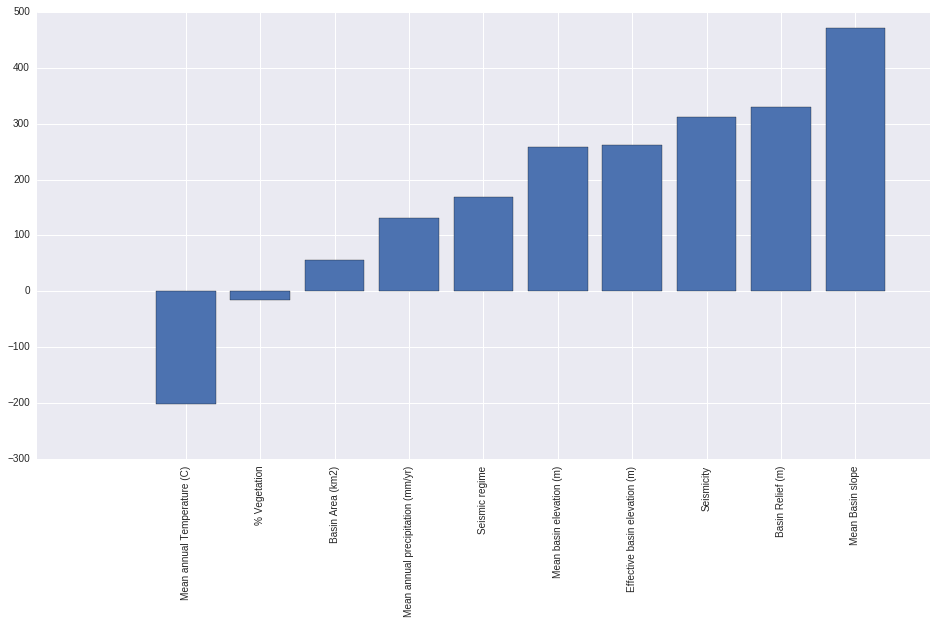

In [153]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.bar(range(len(sorted_weighted_features)), [x[1] for x in sorted_weighted_features], align='center')
plt.xticks(range(len(sorted_weighted_features)), [i[0] for i in sorted_weighted_features], rotation='vertical')
plt.show()

As you can see, the weighted Pearson coefficients state that the *Mean annual Temperature* and the *Vegetation* features correlate negatively.
On the other side, the *Mean Basin slope* has the largest positive correlation on the erosion rate.
Unfortunately, since the sample data is very small, we can't be certain that our results are equal on bigger sample sizes.